## Business Goal
To model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Objective: The company wants to know:

1. Which variables are significant in predicting the price of a house
2. How well those variables describe the price of a house.
3. Also, determine the optimal value of lambda for ridge and lasso regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings(action="ignore")

In [2]:
df=pd.read_csv("train.csv")

# Exploratory Data Analysis

In [3]:
print('shape: ', df.shape)
print('info: ', df.info())

shape:  (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   in

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### As we can see that the target (SalePrice) is continuous Variable which is why we are able to do the <ins>Linear Regression</ins>

## Missing Values

In [5]:
# To calculate the percentage of missing values in every column
temp=(df.isnull().mean()).reset_index()
temp=temp.rename(columns={"index":"Column",0:"Missing %"})
temp=temp.sort_values(by="Missing %",ascending=False)
temp.shape

(81, 2)

In [6]:
# Threshold --> 30%-50%
print('50% null values shape', temp[temp["Missing %"]>0.5].shape)
print('30% null values shape', temp[temp["Missing %"]>0.3].shape)
print('10% null values shape', temp[temp["Missing %"]>0.1].shape)

50% null values shape (4, 2)
30% null values shape (5, 2)
10% null values shape (6, 2)


In [7]:
temp[temp["Missing %"]>0.3]

,Column,Missing %
72,PoolQC,0.995205
74,MiscFeature,0.963014
6,Alley,0.937671
73,Fence,0.807534
57,FireplaceQu,0.472603


## Removing Columns with more than 30% Missing values 

In [8]:
# 1. with more than 30% Missing values
# 2.  the ID Column.
df = df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Id'], axis = 1) 

## Check Rows With Null/NA values

In [9]:
nullvalues = df.isna().sum()
nullvalues[nullvalues>0]

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

## Replace Null/NA Values for Continuous Variables with median 

In [10]:
for column in ['LotFrontage', 'MasVnrArea']:
    df[column].fillna(df[column].median(), inplace=True)

## Replace Null/NA Values for Continuous Variables with mode 

In [11]:
for column in ['GarageCond', 'GarageQual', 'GarageFinish', 'GarageFinish','GarageYrBlt', 'GarageType',
               'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'Electrical' ]:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [12]:
df.shape

(1460, 75)

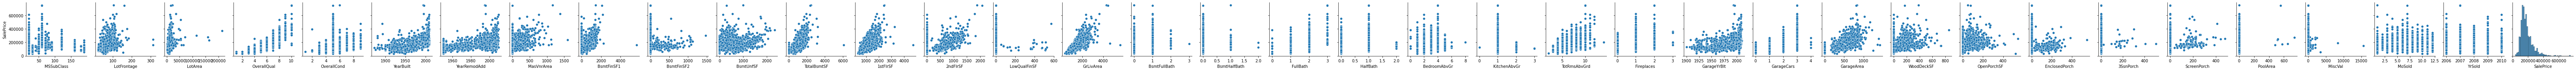

In [13]:
sns.pairplot(data=df,
                  y_vars=['SalePrice'])

# Drop Columsn with  mostly single Values

In [14]:
### As Per Above Plots Based on Above, most of the MiscVals are 0 so dropping that column
df = df.drop(['MiscVal', 'BsmtFinSF2', 'PoolArea', '3SsnPorch', 'LowQualFinSF'], axis = 1) # missing values

# Log Scale Sale Price To make it Normal

In [15]:
df['SalePrice'] = np.log10(df['SalePrice'])

# Outlier Treatment (Remove a few rows with extreme outliers bassed on above graphs)

In [16]:
df = df.drop(df[ (df['FullBath']==0) | (df['BsmtHalfBath']>1) | (df['BsmtFullBath']>2) | 
        (df['ScreenPorch']>390) | (df['EnclosedPorch']>390) |
      (df['TotalBsmtSF']>3500) | (df['BsmtFinSF1']>2000) | 
      (df['MasVnrArea']>1100) | (df['LotArea']>70000) | (df['LotFrontage']>150) | (df['LotArea']>39000) |
               ((df['OverallCond']==2) & (df['SalePrice']>300000)) |
               (df['LotFrontage']>150)].index)
df.shape

(1417, 70)

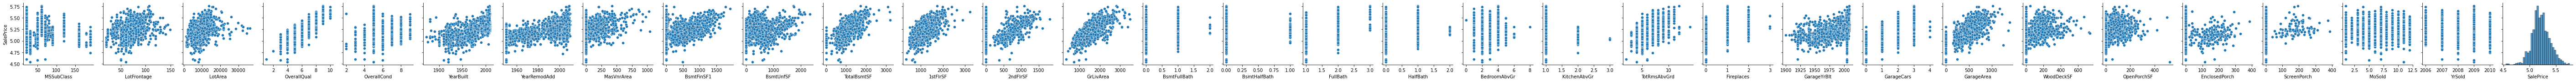

In [17]:
sns.pairplot(data=df,
                  y_vars=['SalePrice'])

In [18]:
df.shape

(1417, 70)

### As we can see from above grphs there are many variables that show linear relation ship with the Target Variable Sale Price.
### So we can proceed with the Multiple Linear Regression

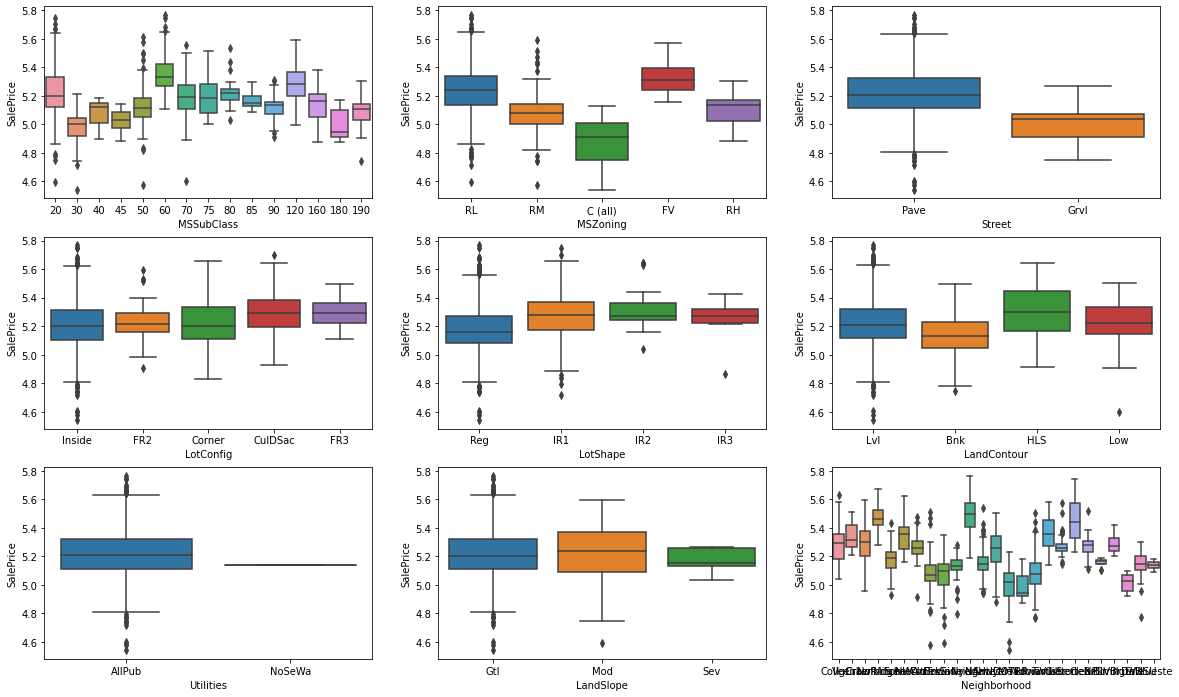

In [19]:
plt.figure(figsize=(20,12))
plt.subplot(3, 3, 1) # We want 3 rows, 3 columns and this is first one
sns.boxplot(x = 'MSSubClass', y = 'SalePrice', data = df)
plt.subplot(3,3,2)
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data = df)
plt.subplot(3,3,3)
sns.boxplot(x = 'Street', y = 'SalePrice', data = df)
plt.subplot(3,3,4)
sns.boxplot(x = 'LotConfig', y = 'SalePrice', data = df)
plt.subplot(3,3,5)
sns.boxplot(x = 'LotShape', y = 'SalePrice', data = df)
plt.subplot(3,3,6)
sns.boxplot(x = 'LandContour', y = 'SalePrice', data = df)
plt.subplot(3,3,7)
sns.boxplot(x = 'Utilities', y = 'SalePrice', data = df)
plt.subplot(3,3,8)
sns.boxplot(x = 'LandSlope', y = 'SalePrice', data = df)
plt.subplot(3,3,9)
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = df)

plt.show()


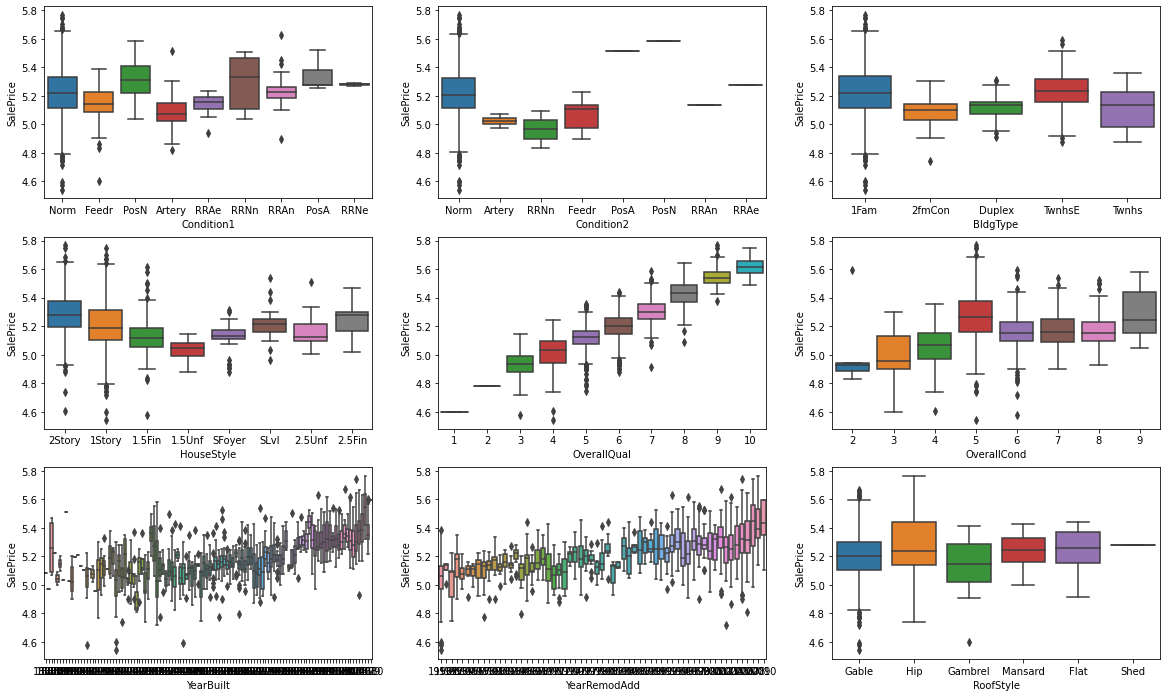

In [20]:
plt.figure(figsize=(20,12))
plt.subplot(3, 3, 1) # We want 3 rows, 3 columns and this is first one
sns.boxplot(x = 'Condition1', y = 'SalePrice', data = df)
plt.subplot(3,3,2)
sns.boxplot(x = 'Condition2', y = 'SalePrice', data = df)
plt.subplot(3,3,3)
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = df)
plt.subplot(3,3,4)
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = df)
plt.subplot(3,3,5)
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df)
plt.subplot(3,3,6)
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data = df)
plt.subplot(3,3,7)
sns.boxplot(x = 'YearBuilt', y = 'SalePrice', data = df)
plt.subplot(3,3,8)
sns.boxplot(x = 'YearRemodAdd', y = 'SalePrice', data = df)
plt.subplot(3,3,9)
sns.boxplot(x = 'RoofStyle', y = 'SalePrice', data = df)

plt.show()


# Create Dummy Variables for Categorical Variables

In [21]:
categoricalColumns = ['MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']
categoricalColumnsDf = df[categoricalColumns]
categoricalColumnsDummies = pd.get_dummies(categoricalColumnsDf, prefix=categoricalColumns, drop_first=True)
categoricalColumnsDummies.shape      



(1417, 194)

In [22]:
#df.drop(categoricalColumnsDummies, axis = 1, inplace = True)
print('categoricalColumnsDummies.shape: ',categoricalColumnsDummies.shape)
print('df.shape: ',df.shape)
df = pd.concat([df, categoricalColumnsDummies], axis = 1)
print('df.shape: ',df.shape)
df.drop(categoricalColumns, axis = 1, inplace = True)
print('df.shape: ',df.shape)

categoricalColumnsDummies.shape:  (1417, 194)
df.shape:  (1417, 70)
df.shape:  (1417, 264)
df.shape:  (1417, 226)


In [23]:
MSSubClass = pd.get_dummies(df['MSSubClass'], drop_first=True)
MSSubClass = MSSubClass.add_prefix('MSSubClass_')
# Add MSSubClass to df
df = pd.concat([df, MSSubClass], axis = 1)
# Drop 'mnth' as we have created the dummies for it
df.drop(['MSSubClass'], axis = 1, inplace = True)



OverallQual = pd.get_dummies(df['OverallQual'], drop_first=True)
OverallQual = OverallQual.add_prefix('OverallQual_')
# Add OverallQual to df
df = pd.concat([df, OverallQual], axis = 1)
# Drop 'mnth' as we have created the dummies for it
df.drop(['OverallQual'], axis = 1, inplace = True)


OverallCond = pd.get_dummies(df['OverallCond'], drop_first=True)
OverallCond = OverallCond.add_prefix('OverallCond_')
# Add OverallCond to df
df = pd.concat([df, OverallCond], axis = 1)
# Drop 'mnth' as we have created the dummies for it
df.drop(['OverallCond'], axis = 1, inplace = True)



MoSold = pd.get_dummies(df['MoSold'], drop_first=True)
MoSold = MoSold.add_prefix('MoSold_')
# Add MoSold to df
df = pd.concat([df, MoSold], axis = 1)
# Drop 'mnth' as we have created the dummies for it
df.drop(['MoSold'], axis = 1, inplace = True)



In [24]:
print('df.shape: ',df.shape)

df.shape:  (1417, 263)


### Splitting the Data into Training and Testing Sets
As you know, the first basic step for regression is performing a train-test split.

In [25]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

print(df_train.shape)
print(df_test.shape)

(991, 263)
(426, 263)


In [26]:
df.shape

(1417, 263)

## Building a linear model

Regression line through the training data using `statsmodels`. 
<br/>With statsmodels we need to add a constant as well. since in `statsmodels` the regression line passes through the origin, by default.

# Using RFE
### Rescaling the Features 

We will use MinMax scaling.

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [28]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
            'TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
            'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
            'GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
            'ScreenPorch','YrSold', 'SalePrice']

# scaler.fit() will learn what needs to be done.
# transform(): transform will actually do it.
# fit_transform(): will learn as well as transform.
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
824,0.487805,0.293087,0.978102,0.933333,0.000000,0.000000,0.637414,0.565515,0.416563,0.000000,...,0,0,0,1,0,0,0,0,0,0
128,0.390244,0.185913,0.686131,0.266667,0.254059,0.268908,0.063356,0.250665,0.073292,0.378438,...,0,0,0,0,1,0,0,0,0,0
690,0.390244,0.092395,0.963504,0.900000,0.140401,0.366071,0.064640,0.322066,0.151139,0.000000,...,0,0,1,0,0,0,0,0,0,0
1316,0.325203,0.263825,0.992701,0.966667,0.257880,0.000000,0.694349,0.616027,0.474948,0.000000,...,0,0,0,0,0,0,0,0,0,0
150,0.804878,0.267668,0.751825,0.416667,0.000000,0.376050,0.108305,0.368021,0.201242,0.000000,...,0,0,0,0,0,0,0,0,0,0


### Dividing into X and Y sets for the model building

In [29]:
y_train = df_train.pop('SalePrice')
X_train = df_train

### Building Model

In [30]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [31]:

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 25) # running RFE
rfe = rfe.fit(X_train, y_train)

In [32]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))
#TRUE: Selected variables are ones with True. (unfurnished and semi-furnished are not included in RFE as they are false)
#1 being the most important variable.
#The numbers beside the variables indicate the importance of that variable. 


[('LotFrontage', False, 109),
 ('LotArea', False, 8),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 9),
 ('MasVnrArea', False, 95),
 ('BsmtFinSF1', False, 47),
 ('BsmtUnfSF', False, 5),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('GrLivArea', False, 91),
 ('BsmtFullBath', False, 96),
 ('BsmtHalfBath', False, 190),
 ('FullBath', False, 103),
 ('HalfBath', False, 81),
 ('BedroomAbvGr', False, 159),
 ('KitchenAbvGr', False, 44),
 ('TotRmsAbvGrd', False, 100),
 ('Fireplaces', False, 117),
 ('GarageYrBlt', False, 115),
 ('GarageCars', True, 1),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 62),
 ('OpenPorchSF', False, 122),
 ('EnclosedPorch', False, 216),
 ('ScreenPorch', False, 53),
 ('YrSold', False, 154),
 ('MSZoning_FV', True, 1),
 ('MSZoning_RH', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', True, 1),
 ('Street_Pave', False, 45),
 ('LotShape_IR2', False, 110),
 ('LotShape_IR3', False, 162),
 ('LotShape_Reg', False, 167),
 ('LandContour_HL

In [33]:
# RFE selected columns
col = X_train.columns[rfe.support_]
col

Index(['YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageCars',
       'GarageArea', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Neighborhood_Crawfor', 'BldgType_Duplex',
       'RoofMatl_Metal', 'Exterior1st_BrkComm', 'ExterCond_Po', 'Heating_Grav',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageCond_Po',
       'OverallQual_2', 'OverallQual_10', 'OverallCond_3'],
      dtype='object')

In [34]:
# RFE NOT selected columns
X_train.columns[~rfe.support_]

Index(['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtUnfSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       ...
       'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8',
       'MoSold_9', 'MoSold_10', 'MoSold_11', 'MoSold_12'],
      dtype='object', length=237)

In [35]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [36]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [37]:
# Running the linear model
lm = sm.OLS(y_train,X_train_rfe).fit()   

In [38]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [39]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     232.7
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:31   Log-Likelihood:                 1555.8
No. Observations:                 991   AIC:                            -3060.
Df Residuals:                     965   BIC:                            -2932.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0738 

### Note that RoofMatl_Metal has pValue much higher than .05
So let's check after dropping that variable. 

# Function to run Regression multiple times

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def LRFunction(X_train_rfe, y_train, colName):
    X = X_train_rfe.drop(colName, 1,)
    # Dropping highly correlated variables and insignificant variables

    # Build a second fitted model
    X_train_rfe = sm.add_constant(X)

    lm = sm.OLS(y_train, X_train_rfe).fit()
    #Let's see the summary of our linear model after removing hum
    print(lm.summary())


    # Calculate the VIFs again for the new model
    X_train_rfe = X_train_rfe.drop(['const'], axis=1)

    vif = pd.DataFrame()
    X = X_train_rfe
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print (vif)
    return lm, X_train_rfe

In [41]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'RoofMatl_Metal') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     241.9
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:31   Log-Likelihood:                 1554.5
No. Observations:                 991   AIC:                            -3059.
Df Residuals:                     966   BIC:                            -2936.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0740 

In [42]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'MSZoning_RL') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     235.3
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:32   Log-Likelihood:                 1524.4
No. Observations:                 991   AIC:                            -3001.
Df Residuals:                     967   BIC:                            -2883.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0774 

In [43]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'MSZoning_RH') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     246.3
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:32   Log-Likelihood:                 1524.4
No. Observations:                 991   AIC:                            -3003.
Df Residuals:                     968   BIC:                            -2890.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0767 

In [44]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'MSZoning_FV') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     257.3
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:32   Log-Likelihood:                 1522.8
No. Observations:                 991   AIC:                            -3002.
Df Residuals:                     969   BIC:                            -2894.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0745 

In [45]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'GarageCars') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     265.1
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:32   Log-Likelihood:                 1514.5
No. Observations:                 991   AIC:                            -2987.
Df Residuals:                     970   BIC:                            -2884.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0721 

In [46]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'TotalBsmtSF') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     253.9
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:32   Log-Likelihood:                 1474.8
No. Observations:                 991   AIC:                            -2910.
Df Residuals:                     971   BIC:                            -2812.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0992 

In [47]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'GarageType_CarPort') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     267.7
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:32   Log-Likelihood:                 1473.9
No. Observations:                 991   AIC:                            -2910.
Df Residuals:                     972   BIC:                            -2817.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1229 

In [48]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'GarageType_Basment') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     283.7
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:19:32   Log-Likelihood:                 1473.8
No. Observations:                 991   AIC:                            -2912.
Df Residuals:                     973   BIC:                            -2823.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1267 

In [49]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'YearBuilt') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     203.7
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          3.55e-297
Time:                        13:19:32   Log-Likelihood:                 1317.7
No. Observations:                 991   AIC:                            -2601.
Df Residuals:                     974   BIC:                            -2518.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2200 

In [50]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'OverallQual_2') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     217.2
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          4.67e-298
Time:                        13:19:32   Log-Likelihood:                 1317.0
No. Observations:                 991   AIC:                            -2602.
Df Residuals:                     975   BIC:                            -2524.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2194 

In [51]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'GarageArea') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     161.8
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          9.29e-243
Time:                        13:19:32   Log-Likelihood:                 1184.3
No. Observations:                 991   AIC:                            -2339.
Df Residuals:                     976   BIC:                            -2265.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2978 

In [52]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'GarageCond_Po') 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     174.2
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          1.21e-243
Time:                        13:19:32   Log-Likelihood:                 1183.8
No. Observations:                 991   AIC:                            -2340.
Df Residuals:                     977   BIC:                            -2271.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2976 

In [53]:
lm, X_train_rfe = LRFunction(X_train_rfe, y_train,'GarageType_Attchd') 


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     182.8
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          5.47e-240
Time:                        13:19:32   Log-Likelihood:                 1172.5
No. Observations:                 991   AIC:                            -2319.
Df Residuals:                     978   BIC:                            -2255.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3737 

In [54]:
X_train_rfe.columns

Index(['1stFlrSF', '2ndFlrSF', 'MSZoning_RM', 'Neighborhood_Crawfor',
       'BldgType_Duplex', 'Exterior1st_BrkComm', 'ExterCond_Po',
       'Heating_Grav', 'GarageType_BuiltIn', 'GarageType_Detchd',
       'OverallQual_10', 'OverallCond_3'],
      dtype='object')

## Now we have a model that has acceptable parameters p-value, VIF and R-square. 

## Residual Analysis of the train data
### Linear Regression Assumption
Check if the error terms are also normally distributed 

In [55]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [56]:
y_train_pred = lm.predict(X_train_rfe)


Text(0.5, 0, 'Errors')

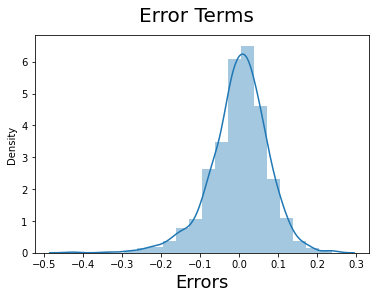

In [57]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Mean of Residuals

In [58]:
np.mean((y_train - y_train_pred))

2.1610698430897345e-16

## Making Predictions Using the Final Model

We have a fitted model and with errors normally distributed.
Next we can make predictions using the final.

In [59]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [60]:
# Dividing into X_test and y_test
y_test = df_test.pop('SalePrice')
X_test = df_test

In [61]:
# Predictions based on our model

# Creating X_test_new dataframe by dropping variables from X_test
X_train_rfe = X_train_rfe.drop(['const'], axis=1)
X_test_rfe = X_test[X_train_rfe.columns]

# Adding a constant variable 
X_test_rfe = sm.add_constant(X_test_rfe)

In [62]:
# Making predictions
y_test_pred = lm.predict(X_test_rfe)

In [63]:
print(X_train_rfe.info())
print(X_test_rfe.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 824 to 817
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1stFlrSF              991 non-null    float64
 1   2ndFlrSF              991 non-null    float64
 2   MSZoning_RM           991 non-null    uint8  
 3   Neighborhood_Crawfor  991 non-null    uint8  
 4   BldgType_Duplex       991 non-null    uint8  
 5   Exterior1st_BrkComm   991 non-null    uint8  
 6   ExterCond_Po          991 non-null    uint8  
 7   Heating_Grav          991 non-null    uint8  
 8   GarageType_BuiltIn    991 non-null    uint8  
 9   GarageType_Detchd     991 non-null    uint8  
 10  OverallQual_10        991 non-null    uint8  
 11  OverallCond_3         991 non-null    uint8  
dtypes: float64(2), uint8(10)
memory usage: 32.9 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 992 to 980
Data columns (total 13 columns):
 #   Column    

Text(0.5, 0, 'Errors')

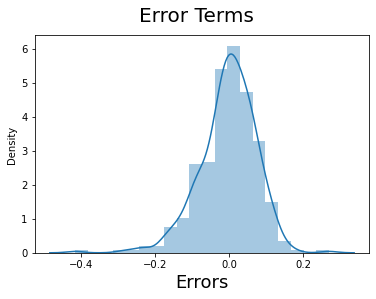

In [64]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Linear Model Evaluation

Plotting the graph for actual versus predicted values of cnt

Text(0, 0.5, 'y_test_pred')

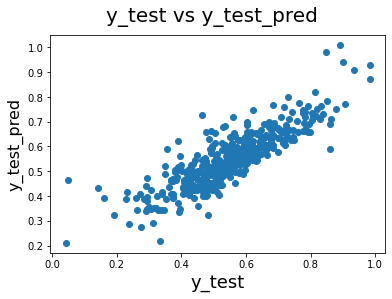

In [65]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16) 

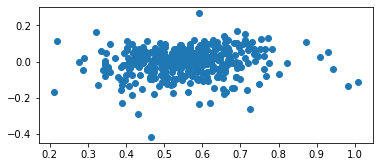

In [66]:
residual = y_test - y_test_pred
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_test_pred, residual)

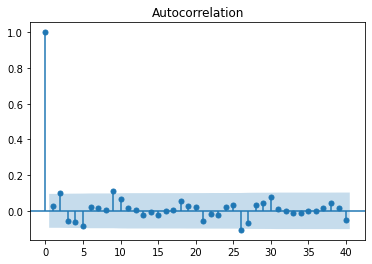

In [67]:
acf = sm.graphics.tsa.plot_acf(residual, lags=40)
# acf = sm.graphics.plot_acf(residual, lags=40 , alpha=0.05)
acf.show()

In [68]:

metric = []
r2_train_lr = r2_score(y_train, y_train_pred)
print('r2_train_lr: ', r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_test_pred)
print('r2_test_lr: ', r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_train_pred))
print('rss1_lr: ', rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_test_pred))
print('rss2_lr: ', rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_train_pred)
print('mse_train_lr: ', mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_test_pred)
print('mse_test_lr: ', mse_test_lr)
metric.append(mse_test_lr**0.5)



r2_train_lr:  0.6916307475917773
r2_test_lr:  0.7226916466353095
rss1_lr:  5.4440278118246805
rss2_lr:  2.478375049949994
mse_train_lr:  0.005493469033122786
mse_test_lr:  0.005817781807394352


# Linear Regression END

# Now Let's Build a Model With Ridge Regression

In [69]:
X_train
y_train

824     0.673691
128     0.529530
690     0.495909
1316    0.758691
150     0.444502
          ...   
827     0.599968
54      0.467060
362     0.617386
81      0.526077
817     0.727959
Name: SalePrice, Length: 991, dtype: float64

In [70]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [71]:
print(model_cv.best_params_)

{'alpha': 5.0}


In [72]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 5.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)


Ridge(alpha=5.0)

In [73]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r2_train_lr', r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r2_test_lr', r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss1_lr', rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss2_lr', rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse_train_lr',mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse_test_lr', mse_test_lr)
metric2.append(mse_test_lr**0.5)

r2_train_lr 0.9383307976882057
r2_test_lr 0.9162903782888132
rss1_lr 1.0887235024133002
rss2_lr 0.7481341090973923
mse_train_lr 0.0010986110014261355
mse_test_lr 0.0017561833546887143


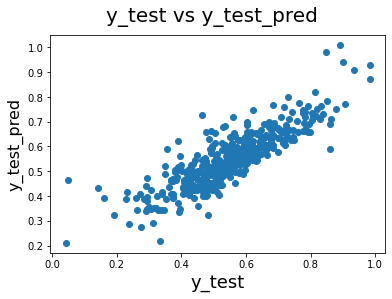

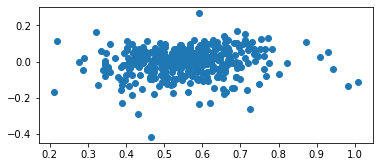

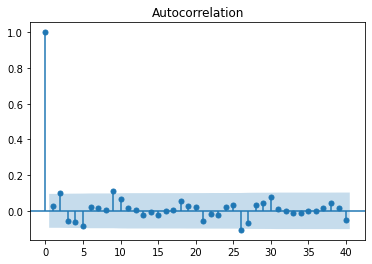

In [74]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16) 

residual = y_test - y_test_pred
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_test_pred, residual)

acf = sm.graphics.tsa.plot_acf(residual, lags=40)
# acf = sm.graphics.plot_acf(residual, lags=40 , alpha=0.05)
acf.show()

## Lasso

In [75]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [76]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [77]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 


Lasso(alpha=0.0001)

In [78]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r2_train_lr', r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r2_test_lr', r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss1_lr', rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss2_lr', rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse_train_lr', mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse_test_lr', mse_test_lr)
metric3.append(mse_test_lr**0.5)

r2_train_lr 0.9374641835670344
r2_test_lr 0.9202458564257583
rss1_lr 1.1040229245863344
rss2_lr 0.7127829982985951
mse_train_lr 0.0011140493689064928
mse_test_lr 0.001673199526522524


## Lasso Model Evaluation 

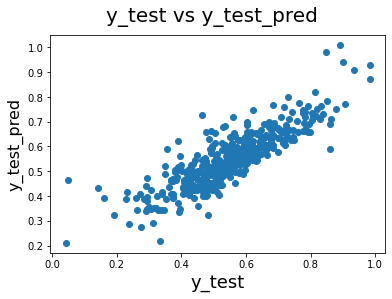

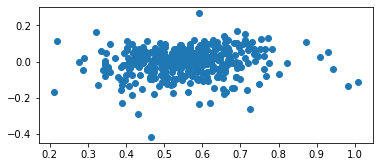

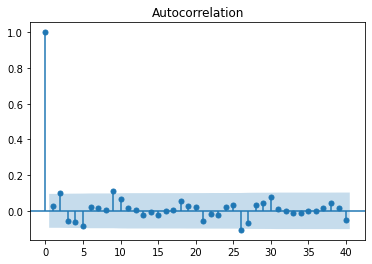

In [79]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16) 

residual = y_test - y_test_pred
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_test_pred, residual)

acf = sm.graphics.tsa.plot_acf(residual, lags=40)
# acf = sm.graphics.plot_acf(residual, lags=40 , alpha=0.05)
acf.show()

In [80]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.691631,0.938331,0.937464
1,R2 Score (Test),0.722692,0.916290,0.920246
2,RSS (Train),5.444028,1.088724,1.104023
3,RSS (Test),2.478375,0.748134,0.712783
4,MSE (Train),0.074118,0.033145,0.033377
5,MSE (Test),0.076274,0.041907,0.040905


### Changes in the coefficients after regularization

In [81]:
betas = pd.DataFrame(index=X_train_rfe.columns)
betas = pd.DataFrame(index=X_train.columns)
# betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
betas

,Ridge,Lasso
LotFrontage,0.019840,0.013225
LotArea,0.036924,0.039707
YearBuilt,0.035904,0.076667
YearRemodAdd,0.032016,0.029537
MasVnrArea,0.014083,0.003037
...,...,...
MoSold_8,0.000959,-0.000124
MoSold_9,0.004822,0.000000
MoSold_10,0.004990,0.003216
MoSold_11,-0.006605,-0.006671


# Top Variables With Ridge Regression


In [82]:
betas = betas.reindex(betas.Ridge.abs().sort_values(ascending = False).index)
betas['Ridge'].head(20)

GrLivArea               0.085335
1stFlrSF                0.068049
TotalBsmtSF             0.061430
2ndFlrSF                0.046368
BsmtFinSF1              0.044937
OverallQual_3          -0.044889
GarageArea              0.039969
Neighborhood_Crawfor    0.039355
GarageCars              0.038800
OverallQual_9           0.038089
LotArea                 0.036924
TotRmsAbvGrd            0.036152
YearBuilt               0.035904
OverallCond_3          -0.034784
OverallQual_4          -0.033691
Neighborhood_MeadowV   -0.033072
HalfBath                0.032655
YearRemodAdd            0.032016
OverallQual_8           0.029257
Heating_Grav           -0.029145
Name: Ridge, dtype: float64

# Top Variables With Lasso Regression

In [83]:
betas = betas.reindex(betas.Lasso.abs().sort_values(ascending = False).index)
#betas['Lasso'].head(20)
betas['Lasso'].head(200)

GrLivArea              0.248292
TotalBsmtSF            0.082956
YearBuilt              0.076667
OverallQual_3         -0.066269
OverallCond_3         -0.051905
                         ...   
Exterior1st_CemntBd    0.000000
MSSubClass_75          0.000000
GarageCond_TA         -0.000000
MSSubClass_40          0.000000
MSSubClass_60          0.000000
Name: Lasso, Length: 200, dtype: float64

## Ridge Regression with double the alpha Value (10.0)

In [84]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 10.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric4 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r2_train_lr', r2_train_lr)
metric4.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r2_test_lr', r2_test_lr)
metric4.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss1_lr', rss1_lr)
metric4.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss2_lr', rss2_lr)
metric4.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse_train_lr',mse_train_lr)
metric4.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse_test_lr', mse_test_lr)
metric4.append(mse_test_lr**0.5)


r2_train_lr 0.9323209826682763
r2_test_lr 0.911865656927016
rss1_lr 1.194822278010762
rss2_lr 0.787678965546911
mse_train_lr 0.0012056733380532412
mse_test_lr 0.0018490116562134061


## Lasso Regression with double alpha (.0002)

In [85]:
alpha = 0.0002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 


# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric5 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('r2_train_lr', r2_train_lr)
metric5.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r2_test_lr', r2_test_lr)
metric5.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss1_lr', rss1_lr)
metric5.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss2_lr', rss2_lr)
metric5.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse_train_lr', mse_train_lr)
metric5.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse_test_lr', mse_test_lr)
metric5.append(mse_test_lr**0.5)


r2_train_lr 0.9303222995811301
r2_test_lr 0.9188681472948731
rss1_lr 1.2301075284969016
rss2_lr 0.7250959340419465
mse_train_lr 0.001241279039855602
mse_test_lr 0.001702103131553865


In [86]:
betas = pd.DataFrame(index=X_train_rfe.columns)
betas = pd.DataFrame(index=X_train.columns)
# betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
betas = betas.reindex(betas.Lasso.abs().sort_values(ascending = False).index)
betas.head(20)

,Ridge,Lasso
GrLivArea,0.073997,0.260599
TotalBsmtSF,0.053681,0.088433
OverallQual_9,0.034900,0.063857
YearBuilt,0.024091,0.058322
OverallQual_10,0.023117,0.057125
OverallQual_3,-0.037049,-0.051766
OverallCond_3,-0.028844,-0.050368
GarageArea,0.037497,0.045060
Neighborhood_Crawfor,0.035176,0.044367
BsmtFinSF1,0.041039,0.041080


In [87]:
betas = pd.DataFrame(index=X_train_rfe.columns)
betas = pd.DataFrame(index=X_train.columns)
# betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
betas = betas.reindex(betas.Ridge.abs().sort_values(ascending = False).index)
betas.head(20)

,Ridge,Lasso
GrLivArea,0.073997,0.260599
1stFlrSF,0.060454,0.000000
TotalBsmtSF,0.053681,0.088433
BsmtFinSF1,0.041039,0.041080
GarageCars,0.038050,0.037931
2ndFlrSF,0.038026,0.000000
GarageArea,0.037497,0.045060
OverallQual_3,-0.037049,-0.051766
TotRmsAbvGrd,0.036925,0.001195
Neighborhood_Crawfor,0.035176,0.044367


In [88]:
X_train.shape

(991, 262)

# Lasso Model after dropping first 5 most important predictors

In [89]:
LassoTop5columnsToDrop = ['GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'OverallQual_3', 'OverallCond_3']
#df = df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Id'], axis = 1) 
X_train = X_train.drop(LassoTop5columnsToDrop, axis = 1) 
X_test = X_test.drop(LassoTop5columnsToDrop, axis = 1) 

In [90]:
X_train.shape

(991, 257)

In [91]:
lasso = Lasso()
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = 5, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 
print(model_cv.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'alpha': 0.0001}


In [92]:
alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 


Lasso(alpha=0.0001)

In [93]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

r2_train_lr = r2_score(y_train, y_pred_train)
print('r2_train_lr', r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('r2_test_lr', r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('rss1_lr', rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('rss2_lr', rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('mse_train_lr', mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('mse_test_lr', mse_test_lr)



r2_train_lr 0.9344438536308391
r2_test_lr 0.9151850908849386
rss1_lr 1.1573445837502212
rss2_lr 0.7580123428092509
mse_train_lr 0.001167855281281757
mse_test_lr 0.0017793716967353307


In [94]:
betas = pd.DataFrame(index=X_train.columns)
# betas['Linear'] = lm.coef_
betas['Lasso'] = lasso.coef_
betas = betas.reindex(betas.Lasso.abs().sort_values(ascending = False).index)
betas.head(20)

,Lasso
1stFlrSF,0.205944
2ndFlrSF,0.137788
BsmtFinSF1,0.082888
OverallQual_9,0.074897
OverallQual_10,0.066997
OverallQual_8,0.052214
Heating_Grav,-0.051830
BsmtUnfSF,0.050392
Neighborhood_Crawfor,0.045099
OverallCond_9,0.044881
